In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

## O conjunto de dados

A base de dados utilizada será uma versão rotulada da base de dados disponível como material auxiliar do livro "Solomon, C., & Breckon, T. (2010). Fundamentals of Digital Image Processing. Wiley. https://doi.org/10.1002/9780470689776". A base de dados está disponível em https://www.fundipbook.com/materials/ e contém 141 imagens com garrafas que podem conter algum tipo de defeito. Entretanto, temos apenas 77 imagens rotuladas, logo, apenas essas serão utilizadas para avaliação.

As categorias de defeitos que existem no conjunto de dados são as seguintes:

* CONTENT_HIGH -> Líquido mais alto que o normal
* CONTENT_LOW -> Líquido mais baixo que o normal
* COVER_NONE -> Sem a tampa 
* BOTTLE_SMASHED -> Garrafa amassada
* LABEL_WHITE -> Rótulo em branco
* LABEL_MISPLACED -> Rótulo errado
* LABEL_NONE -> Rótulo vazio
* BOTTLE_NONE -> Garrafa inexistente


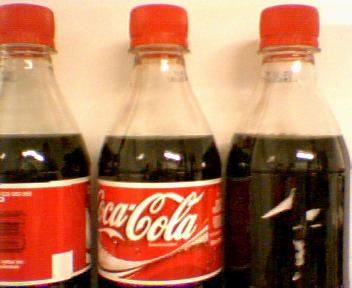

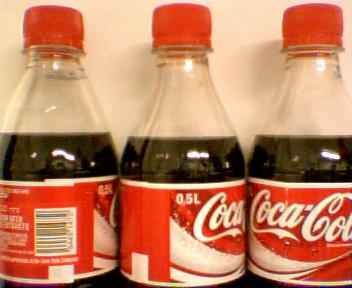

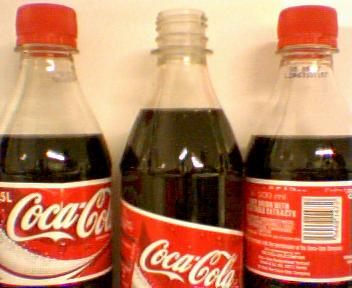

In [33]:
# Some of the images

from IPython.display import Image as DisplayImg
from IPython.display import display

x = DisplayImg(filename='./bottles/train/train_1.jpg',width=224)
y = DisplayImg(filename='./bottles/train/train_2.jpg',width=224)
z = DisplayImg(filename='./bottles/train/train_3.jpg',width=224)
display(x,y,z)

In [34]:
# DataFrame with labels 

df = pd.read_csv('./train.csv')
df.head()


,filename,CONTENT_HIGH,CONTENT_LOW,COVER_NONE,BOTTLE_SMASHED,LABEL_WHITE,LABEL_MISPLACED,LABEL_NONE,BOTTLE_NONE
0,train_1.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train_2.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train_3.jpg,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN
3,train_4.jpg,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,train_5.jpg,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [35]:
df.columns

Index(['filename', 'CONTENT_HIGH', 'CONTENT_LOW', 'COVER_NONE',
       'BOTTLE_SMASHED', 'LABEL_WHITE', 'LABEL_MISPLACED', 'LABEL_NONE',
       'BOTTLE_NONE'],
      dtype='object')

## O projeto

O projeto envolve a classificação de garrafas defeituosas em uma linha de produção da Coca-Cola. A partir de diferentes imagens de garrafas em uma linha de produção, identificar se existe ou não algum tipo de defeito na garrafa, como a falta da marca, a garrafa estar vazia ou danificada, entre outros. O conjunto de dados é composto sempre por fotos de 3 garrafas, mas para este projeto sempre iremos avaliar a garrafa do meio. 

As categorias de defeito existentes no conjunto de dados, que serão o alvo da classificação, são:

* CONTENT_HIGH -> Líquido mais alto que o normal
* CONTENT_LOW -> Líquido mais baixo que o normal
* COVER_NONE -> Sem a tampa 
* BOTTLE_SMASHED -> Garrafa amassada
* LABEL_WHITE -> Rótulo em branco
* LABEL_MISPLACED -> Rótulo errado
* LABEL_NONE -> Rótulo vazio
* BOTTLE_NONE -> Garrafa inexistente


Como temos a rotulação correta das 77 imagens, a avaliação será por acurácia e matriz de confusão: quantas falhas ele conseguiu identificar corretamente. Para fins de sucesso mínimo, o algoritmo deverá ser capaz de superar um DummyClassifier, que neste dataset tem uma acurácia de 56%.


### Pré-processamento

Foram realizadas algumas etapas de pré-processamento. A primeira delas foi transformar o dataset que tínhamos com as rotulações em um DataFrame que pudesse ser aplicado em classificadores como o KNN e SVM.

Após isso, ajustes nas imagens como cortes para manter o foco na garrafa do centro, de modo que as garrafas laterais não influenciassem no resultado também foram realizados. Em conjunto, transformações para redimensionamento foram feitas.

Para fins de classificação, foram criados embeddings de imagens utilizando a seguinte ResNet: "ResNet18" do trabalho de: He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.


### Transformação do dataset


In [36]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./train.csv')

# Transforming the train.csv to a classification problem
def transformToClassification(row):
    if row['CONTENT_HIGH'] == 1:
        return 'content_high'
    elif row['CONTENT_LOW'] == 1:
        return 'content_low'
    elif row['BOTTLE_SMASHED'] == 1:
        return 'bottle_smashed'
    elif row['LABEL_WHITE'] == 1:
        return 'label_white'
    elif row['LABEL_MISPLACED'] == 1:
        return 'label_misplaced'
    elif row['LABEL_NONE'] == 1:
        return 'label_none'
    elif row['BOTTLE_NONE'] == 1:
        return 'bottle_none'
    else:
        return 'normal'

df['class'] = df.apply(transformToClassification, axis=1)
result = df[['filename', 'class']]
print(result)

        filename           class
0    train_1.jpg          normal
1    train_2.jpg          normal
2    train_3.jpg    content_high
3    train_4.jpg    content_high
4    train_5.jpg    content_high
..           ...             ...
72  train_73.jpg          normal
73  train_74.jpg  bottle_smashed
74  train_75.jpg    content_high
75  train_76.jpg    content_high
76  train_77.jpg          normal

[77 rows x 2 columns]


### Embbedings e Ajustes das Imagens

In [37]:

# Model related to ResNet18
model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

/home/felipe/code/usp/mineracao_dados/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/felipe/code/usp/mineracao_dados/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
import numpy as np
from PIL import Image


scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()


# Cropping function to help get the middle bottle
def centralizingImage(img, new_size):
    
    width, height = img.size
    new_width, new_height = new_size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height

    return img.crop((left, top, right, bottom))


def generate_embeddings(img_file):
    img = Image.open(img_file)
    central_img = centralizingImage(img, (150, 255))
    transformed_img = Variable(normalize(to_tensor(scaler(central_img))).unsqueeze(0))

    embedding = torch.zeros(512) # armazenado espaço

    def embedding_f(m, i, o):
        embedding.copy_(o.data.reshape(o.data.size(1)))

    # capturando embeddings
    h = layer.register_forward_hook(embedding_f)
    model(transformed_img)

    h.remove()

    return np.array(embedding)


In [39]:

em1 = generate_embeddings("./bottles/train/train_1.jpg")
em2 = generate_embeddings("./bottles/train/train_2.jpg")

print(em1)

[0.2500936  0.29862806 0.8668492  1.5010593  0.         0.18910083
 0.29518032 0.6713862  0.33958843 0.1750259  1.2791762  2.0483587
 2.3178694  0.6705836  0.6415969  0.44943812 3.586549   0.342297
 0.8971042  0.0415022  1.4192957  0.0456854  0.09260479 0.4712999
 0.9154462  0.06578399 0.09738295 1.0557894  0.89343184 0.7819842
 2.1291432  0.4853799  1.0963376  0.0119194  2.4046166  0.48659593
 1.3735915  1.2406088  0.29102263 1.5529684  0.5877029  0.58075386
 0.82657826 1.0720736  0.33119035 0.29735658 0.32566068 0.2972781
 0.27152282 0.22156093 0.9888662  0.2219991  2.8910902  1.4709034
 1.5974607  2.551198   0.18707664 0.20178242 0.65722865 0.7446741
 0.93632483 0.2861595  0.9339556  3.7784314  0.43792033 0.5480741
 0.7998603  0.         1.9903609  0.66191554 1.7740477  2.808332
 0.7069031  0.65758574 0.40675133 2.948336   0.5230855  0.20300213
 0.56817406 0.840329   1.0894674  1.9560294  1.2806532  1.4200394
 0.768587   0.774925   0.53130114 0.6252221  0.925106   0.95796716
 0.7973

/tmp/ipykernel_522489/3684104639.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(embedding)


In [40]:
base_path = f"./bottles/train/"

result['embedding'] = result['filename'].apply(lambda x: generate_embeddings(base_path+x))
result

/tmp/ipykernel_522489/3684104639.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(embedding)
/tmp/ipykernel_522489/2610370157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['embedding'] = result['filename'].apply(lambda x: generate_embeddings(base_path+x))


,filename,class,embedding
0,train_1.jpg,normal,"[0.2500936, 0.29862806, 0.8668492, 1.5010593, ..."
1,train_2.jpg,normal,"[0.034773987, 0.36840016, 1.0091888, 1.154968,..."
2,train_3.jpg,content_high,"[0.30469382, 0.88139266, 1.0159869, 1.1083338,..."
3,train_4.jpg,content_high,"[0.35833362, 0.520968, 0.32460353, 0.18693168,..."
4,train_5.jpg,content_high,"[0.11395779, 0.10551458, 0.1779632, 0.5547991,..."
...,...,...,...
72,train_73.jpg,normal,"[0.11126861, 0.28137904, 0.60515755, 1.2520286..."
73,train_74.jpg,bottle_smashed,"[0.25781953, 0.28069937, 0.26034412, 1.4017156..."
74,train_75.jpg,content_high,"[0.09230651, 0.21868706, 0.49398166, 1.2426761..."
75,train_76.jpg,content_high,"[0.3010686, 0.3601391, 0.78575563, 1.5109802, ..."


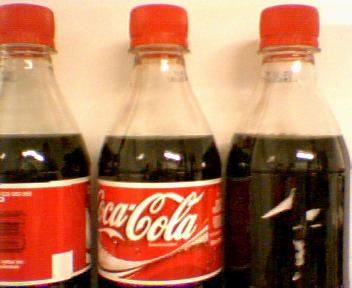

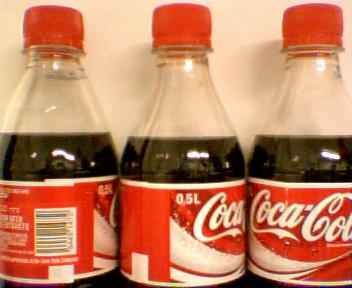

0.079897106


In [41]:
# Example of dissimilarity

from scipy.spatial import distance

x = DisplayImg(filename='./bottles/train/train_1.jpg',width=224)
y = DisplayImg(filename='./bottles/train/train_2.jpg',width=224)
display(x, y)

print(distance.cosine(em1, em2))

### Classificador


In [42]:
from sklearn.model_selection import train_test_split

X = result.drop(columns=["class"])
y_target = result["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.3, random_state=42)
X_test


,filename,embedding
4,train_5.jpg,"[0.11395779, 0.10551458, 0.1779632, 0.5547991,..."
35,train_36.jpg,"[0.45943043, 0.5166473, 0.024825986, 1.3206279..."
10,train_11.jpg,"[0.23156357, 0.19898556, 0.099137045, 1.340282..."
0,train_1.jpg,"[0.2500936, 0.29862806, 0.8668492, 1.5010593, ..."
45,train_46.jpg,"[0.13341936, 0.25412455, 0.16626735, 1.393098,..."
47,train_48.jpg,"[0.16977225, 0.59450537, 0.44274116, 1.5264409..."
66,train_67.jpg,"[0.12451023, 1.111525, 0.15377462, 1.6547967, ..."
53,train_54.jpg,"[0.33028513, 0.28458732, 0.08989739, 0.7559834..."
50,train_51.jpg,"[0.3173561, 0.9211476, 1.3702902, 1.3368485, 0..."
28,train_29.jpg,"[0.10381253, 0.57205904, 0.20481305, 1.657373,..."


### Dummy

Com o Dummy obtivemos uma acurácia de 29%, o que é considerada baixa. 

In [44]:
# DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.2916666666666667


### KNN

Rodando o classificador KNN pela primeira vez com parâmetros bases como k=3 , obtemos um valor de acurácia de 83%, o que já é um valor considerado bom, porém, iremos realizar a busca dos melhores hiperparâmetros.

In [79]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3,metric="cosine")
knn.fit(np.array(X_train.embedding.to_list()), y_train)
y_pred = knn.predict(np.array(X_test.embedding.to_list()))
y_pred


array(['content_high', 'label_none', 'normal', 'normal', 'normal',
       'normal', 'content_high', 'label_none', 'content_high', 'normal',
       'normal', 'content_high', 'content_high', 'bottle_none',
       'bottle_none', 'content_high', 'content_high', 'content_high',
       'normal', 'content_high', 'normal', 'normal', 'label_white',
       'content_low'], dtype=object)

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 bottle_none       1.00      1.00      1.00         2
content_high       1.00      0.90      0.95        10
 content_low       1.00      0.50      0.67         2
  label_none       1.00      1.00      1.00         2
 label_white       1.00      1.00      1.00         1
      normal       0.78      1.00      0.88         7

    accuracy                           0.92        24
   macro avg       0.96      0.90      0.91        24
weighted avg       0.94      0.92      0.91        24



In [81]:
# Cross Validaton
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X_train.embedding.to_list(),y_train, cv=3)
print("Acc:", np.mean(scores))


Acc: 0.8485838779956426


### SVM

Para fins de comparação, iremos executar o SVM. O SVM obteve uma métrica menor do que o KNN, então seguiremos com o KNN.

In [78]:
# Comparing to SVM:
from sklearn.svm import SVC

svm = SVC(kernel="linear", C=0.025, random_state=42)
svm.fit(np.array(X_train.embedding.to_list()), y_train)
y_pred = svm.predict(np.array(X_test.embedding.to_list()))
y_pred


array(['content_high', 'label_none', 'normal', 'normal', 'content_low',
       'normal', 'content_low', 'label_none', 'content_high', 'normal',
       'normal', 'content_high', 'content_high', 'bottle_none',
       'bottle_none', 'content_high', 'content_high', 'content_high',
       'normal', 'label_none', 'normal', 'normal', 'label_white',
       'content_low'], dtype=object)

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 bottle_none       1.00      1.00      1.00         2
content_high       1.00      0.70      0.82        10
 content_low       0.67      1.00      0.80         2
  label_none       0.67      1.00      0.80         2
 label_white       1.00      1.00      1.00         1
      normal       0.88      1.00      0.93         7

    accuracy                           0.88        24
   macro avg       0.87      0.95      0.89        24
weighted avg       0.91      0.88      0.87        24



In [69]:
# Cross Validaton
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm, X_train.embedding.to_list(),y_train, cv=3)
print("Acc:", np.mean(scores))


Acc: 0.8856209150326797


### Busca pelos melhores parâmetros

In [55]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

knn_clean = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn_clean,
    param_grid={
        "n_neighbors":[n for n in range(2,10)],
        'metric':['cosine','euclidean','minkowski'],
        'weights':['uniform','distance']
    },
    scoring="accuracy",
    cv=3,
    error_score="raise"
)

grid_search.fit(X_train.embedding.to_list(),y_train)

print(grid_search.best_score_)
print(grid_search.best_estimator_)
print()

0.9237472766884531
KNeighborsClassifier(metric='cosine', n_neighbors=2)



Os melhores parâmetros encontrados foram: metric='cosine', n_neighbors=2. Iremos executar com esses parâmetros para obtermos assim a acurácia de 92% na validação cruzada e 96% no fold em específico.

In [58]:
# KNN with best scores

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2,metric="cosine")
knn.fit(np.array(X_train.embedding.to_list()), y_train)
y_pred = knn.predict(np.array(X_test.embedding.to_list()))

print(classification_report(y_test, y_pred))
# Cross Validaton

scores = cross_val_score(knn, X_train.embedding.to_list(),y_train, cv=3)
print("Acc:", np.mean(scores))


              precision    recall  f1-score   support

 bottle_none       1.00      1.00      1.00         2
content_high       1.00      0.90      0.95        10
 content_low       1.00      1.00      1.00         2
  label_none       1.00      1.00      1.00         2
 label_white       1.00      1.00      1.00         1
      normal       0.88      1.00      0.93         7

    accuracy                           0.96        24
   macro avg       0.98      0.98      0.98        24
weighted avg       0.96      0.96      0.96        24

Acc: 0.9237472766884531


### Avaliação dos Resultados

Podemos visualizar que com uma busca pelos melhores parâmetros do KNN, conseguimos chegar nos valores: K=2, metrics="cosine", weights="uniform". Isso resultou em uma acurácia de 92% quando utilizado a validação cruzada. ALém disso, tivemos excelentes valores de precision e recall que são corroborados pela matriz de confusão abaixo.

O valor de acurácia apresentado é bem maior do que o DummyClassifier, indicando que a combinação de KNN com os embbedings da ResNet18 conseguem identificar corretamente os tipos de defeitos encontrados em garrafas de Coca-Cola.

Para melhorar esses resultados, poderiam ser realizados ajustes finos e a geração de mais imagens rotuladas para o ambiente. Porém, ou por motivos de limitações computacionais, ou por fugir do escopo da disciplina, ambas estratégias não foram realizadas.

### Matriz de Confusão

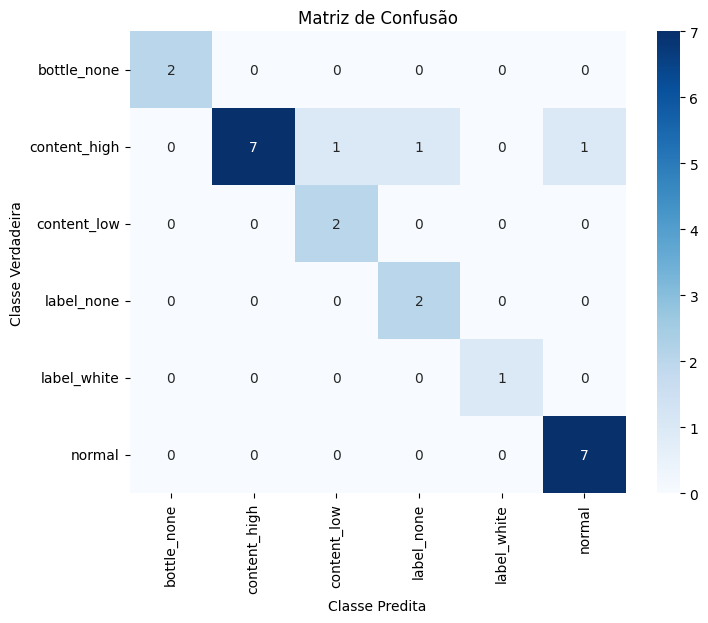

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Classe Predita")
plt.ylabel("Classe Verdadeira")
plt.title("Matriz de Confusão")
plt.show()

## Demo

Para a demo abaixo você poderá escolher dentre qualquer imagem com número entre 78 e 144. As imagens não estão rotuladas e não fazem parte do conjunto de treino e teste utilizado.

Basta modificar a variavel "número" abaixo com um valor entre 78 e 144.

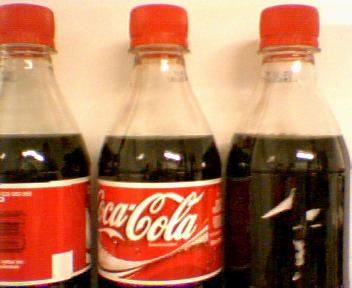

['normal']


/tmp/ipykernel_522489/3684104639.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(embedding)


In [75]:
numero = 1
img_path = f"./bottles/train/train_{numero}.jpg"
x = DisplayImg(filename='./bottles/train/train_1.jpg',width=224)
display(x)

print(knn.predict(generate_embeddings(img_path).reshape(1, -1)))